In [1]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [94]:
df = pd.read_csv('HME020030N.csv', parse_dates=[0])

In [95]:
# remove 0 data from tags positions

tags_columns_list = list(df)[64:114]
overall_max = 0
for col in tags_columns_list:
    current_max = df.loc[:, col].max()
    overall_max = current_max if current_max > overall_max else overall_max

# replace all zeros with overall_max
for col in tags_columns_list:
    df.loc[:, col] = df.loc[:, col].map(lambda x: x if x != 0 else overall_max)
    
# replace fractional numbers(aggregated from the wrong data) by NaN
for col in  tags_columns_list:
    df.loc[:, col] = df.loc[:, col].map(lambda x: x if x == np.int(x) else np.nan)

In [96]:
df_train = df.dropna(subset=['target'])

In [97]:
df_train.columns = ['date'] + df_train.columns.to_list()[1:]

In [98]:
for freq in ['1M', '1Q', '1Y']:
    df_train.fillna(df_train.groupby(pd.Grouper(key='date', freq=freq)).transform('mean'), inplace=True)  

In [99]:
df_train = df_train.resample('1W', on='date').mean()
df_train.reset_index(inplace=True)

In [100]:
df_train.head()

,date,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,dehumidifiers_trend,30 pint dehumidifier_ara,30 pint dehumidifier_trend,air purifier_ara,air purifier_trend,dehumidifiers for basements_ara,dehumidifiers for basements_trend,dehumidifier 70 pint_ara,dehumidifier 70 pint_trend,dehumidifier for bathroom_ara,dehumidifier for bathroom_trend,small dehumidifier_ara,small dehumidifier_trend,50 pint dehumidifier_ara,50 pint dehumidifier_trend,dehumidifier small_ara,dehumidifier small_trend,dehumidifier with drain hose_ara,dehumidifier with drain hose_trend,70 pint dehumidifier_ara,70 pint dehumidifier_trend,closet dehumidifier_ara,closet dehumidifier_trend,safe dehumidifier_ara,safe dehumidifier_trend,dehumidifier air purifier_ara,dehumidifier air purifier_trend,dehumidifier for basements_ara,dehumidifier for basements_trend,bathroom dehumidifier_ara,bathroom dehumidifier_trend,basement dehumidifier_ara,basement dehumidifier_trend,whole house dehumidifier_ara,whole house dehumidifier_trend,portable dehumidifier_ara,portable dehumidifier_trend,dehumidifier for rv_ara,dehumidifier for rv_trend,dehumidifier hose_ara,dehumidifier hose_trend,inventory_fbm,inventory_fba,phase_Sustain_SoldOut,phase_Sustain,AVGSalePrice,Holiday_Christmas Day,Holiday_Columbus Day,Holiday_Independence Day,Holiday_Labor Day,Holiday_Martin Luther King Jr. Day,Holiday_Memorial Day,Holiday_New Year Day,Holiday_Presidents Day (Washingtons Birthday),Holiday_Thanksgiving Day,Holiday_Veterans Day,dehumidifier 50 pint,dehumidifier,dehumidifiers for home,dehumidifier 30 pint,dehumidifiers,30 pint dehumidifier,air purifier,dehumidifiers for basements,dehumidifier 70 pint,dehumidifier for bathroom,small dehumidifier,compact dehumidifier,energy efficient dehumidifier,50 pint dehumidifier,dehumidifier small,dehumidifier with drain hose,home dehumidifier,70 pint dehumidifier,dehumidifier for safe,closet dehumidifier,dehumidifier for home,dehumidifiers with pump,energy star dehumidifier,safe dehumidifier,dehumidifier air purifier,small dehumidifiers for rv,mid size dehumidifier,room dehumidifier,room dehumidifiers for home,small dehumidifiers,dehumidifier for basements,bathroom dehumidifier,dehumidifier 30 pt,dehumidifier for bedroom,dehumidifier for basement,30 pint dehumidifiers,basement dehumidifier,basement dehumidifiers for home,whole house dehumidifier,portable dehumidifier,small room dehumidifier,dehumidifier auto shut off,dehumidifier for rv,dehumidifier with hose,dehumidifier with hose drain,crawl space dehumidifier,dehumidifier hose,dehumidifier energy star,small dehumidifier for bathroom,dehumidifier 70,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,target
0,2017-07-16,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,52.125,123508.0,49.625,-268.0,51.0,1177.0,15.375,24108.5,44.375,54927.5,25.375,86582.0,55.75,122069.5,29.0,303608.5,60.625,114815.5,17.625,31603.5,37.875,80672.5,22.0,47186.0,26.875,170428.0,81.25,21663.0,17.875,163749.0,23.125,146125.0,41.875,298290.0,60.25,212112.0,18.125,371757.0,49.375,-47796.5,38.875,0.410084,0.033696,0.0,0.0,144.990000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,50.0,34.000000,4.000000,22.166667,4.428571,4.125000,3.875000,6.736842,2.888889,3.500000,7.000000,4.166667,48.826087,48.070158,49.37663,47.289984,48.457981,50.0,47.109239,45.237733,48.543478,45.990217,42.353494,49.225,49.771351,44.588043,45.031695,44.711655,50.0,46.415157,48.434783,2.833333,2.000000,10.355556,13.333333,49.148741,50.0,45.997365,50.0,46.839674,46.259783,47.182065,14.014822,19.2,47.794466,49.191304,47.619565,50.0,47.794466,0.093085,0.379679,2017.0,7.000000,28.0,13.500000,3.5,194.5,0.000000,0.000000,0.0,0.0,0.0,0.0,41.166667
1,2017-07-23,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,52.125,123508.0,4

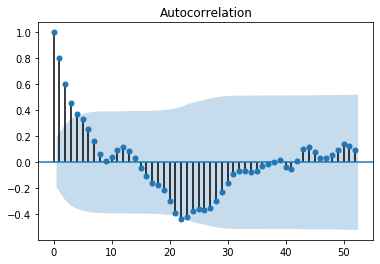

In [101]:
plot_acf(df_train['target'], lags=52, alpha=0.05)
plt.show()

# Select features

In [102]:
df_train['Quarter'] = df_train['Month'].map(lambda x: int((np.round(x) - 1) // 3 + 1))

In [103]:
quarter_ohe = OneHotEncoder()
# weekday_ohe = OneHotEncoder()
quarter_encoded = quarter_ohe.fit_transform(df_train.Quarter.values.reshape(-1,1)).toarray()
# weekday_encoded = weekday_ohe.fit_transform(df_train.Dayofweek.values.reshape(-1,1)).toarray()

In [104]:
quarter_encoded.shape

(103, 4)

In [105]:
df_train.shape

(103, 130)

In [106]:
dfOneHot = pd.DataFrame(quarter_encoded, columns = ["Quarter_"+str(int(i) + 1) for i in range(quarter_encoded.shape[1])])
df_train = pd.concat([df_train, dfOneHot], axis=1)

# dfOneHot = pd.DataFrame(weekday_encoded, columns = ["Dayofweek_"+str(int(i) + 1) for i in range(weekday_encoded.shape[1])])
# df_train = pd.concat([df_train, dfOneHot], axis=1)

In [107]:
df_train = df_train.drop(columns=['date','Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Quarter'])

In [109]:
PREV_DAYS_TO_INCLUDE = 2
for shift in range(1, PREV_DAYS_TO_INCLUDE + 1):
    df_train['target_shifted_' + str(shift)] = df_train['target'].shift(shift)
df_train.dropna(subset=['target_shifted_' + str(shift) for shift in range(1, PREV_DAYS_TO_INCLUDE + 1)], inplace=True)

In [110]:
df_train.tail()

,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,dehumidifiers_trend,30 pint dehumidifier_ara,30 pint dehumidifier_trend,air purifier_ara,air purifier_trend,dehumidifiers for basements_ara,dehumidifiers for basements_trend,dehumidifier 70 pint_ara,dehumidifier 70 pint_trend,dehumidifier for bathroom_ara,dehumidifier for bathroom_trend,small dehumidifier_ara,small dehumidifier_trend,50 pint dehumidifier_ara,50 pint dehumidifier_trend,dehumidifier small_ara,dehumidifier small_trend,dehumidifier with drain hose_ara,dehumidifier with drain hose_trend,70 pint dehumidifier_ara,70 pint dehumidifier_trend,closet dehumidifier_ara,closet dehumidifier_trend,safe dehumidifier_ara,safe dehumidifier_trend,dehumidifier air purifier_ara,dehumidifier air purifier_trend,dehumidifier for basements_ara,dehumidifier for basements_trend,bathroom dehumidifier_ara,bathroom dehumidifier_trend,basement dehumidifier_ara,basement dehumidifier_trend,whole house dehumidifier_ara,whole house dehumidifier_trend,portable dehumidifier_ara,portable dehumidifier_trend,dehumidifier for rv_ara,dehumidifier for rv_trend,dehumidifier hose_ara,dehumidifier hose_trend,inventory_fbm,inventory_fba,phase_Sustain_SoldOut,phase_Sustain,AVGSalePrice,Holiday_Christmas Day,Holiday_Columbus Day,Holiday_Independence Day,Holiday_Labor Day,Holiday_Martin Luther King Jr. Day,Holiday_Memorial Day,Holiday_New Year Day,Holiday_Presidents Day (Washingtons Birthday),Holiday_Thanksgiving Day,Holiday_Veterans Day,dehumidifier 50 pint,dehumidifier,dehumidifiers for home,dehumidifier 30 pint,dehumidifiers,30 pint dehumidifier,air purifier,dehumidifiers for basements,dehumidifier 70 pint,dehumidifier for bathroom,small dehumidifier,compact dehumidifier,energy efficient dehumidifier,50 pint dehumidifier,dehumidifier small,dehumidifier with drain hose,home dehumidifier,70 pint dehumidifier,dehumidifier for safe,closet dehumidifier,dehumidifier for home,dehumidifiers with pump,energy star dehumidifier,safe dehumidifier,dehumidifier air purifier,small dehumidifiers for rv,mid size dehumidifier,room dehumidifier,room dehumidifiers for home,small dehumidifiers,dehumidifier for basements,bathroom dehumidifier,dehumidifier 30 pt,dehumidifier for bedroom,dehumidifier for basement,30 pint dehumidifiers,basement dehumidifier,basement dehumidifiers for home,whole house dehumidifier,portable dehumidifier,small room dehumidifier,dehumidifier auto shut off,dehumidifier for rv,dehumidifier with hose,dehumidifier with hose drain,crawl space dehumidifier,dehumidifier hose,dehumidifier energy star,small dehumidifier for bathroom,dehumidifier 70,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,target,Quarter_1,Quarter_2,Quarter_3,Quarter_4,target_shifted_1,target_shifted_2
98,182364.0,58.592857,278.5,75.189286,7985.571429,31.339286,115269.142857,60.192857,11390.714286,61.525,111426.428571,62.246429,562.857143,21.2,3611.571429,33.060714,41220.214286,74.146429,48303.357143,25.832143,47759.142857,47.5,129673.071429,58.592857,258467.785714,57.060714,74619.642857,25.075,69312.642857,66.796429,150195.785714,27.071429,49803.428571,31.882143,234406.571429,41.785714,111558.857143,17.217857,103368.285714,13.482143,28393.428571,72.010714,38590.571429,54.121429,94733.142857,55.775,376054.595238,36.572619,114965.214286,54.689286,0.883037,0.0,0.0,1.0,386.090135,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,49.470366,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,4.134660,50.0,50.0,50.0,50.0,50.0,50.0,50.0,20.0,50.0,3.304450,50.0,50.0,50.0,50.0,50.0,50.0,17.311475,50.0,50.0,50.0,50.0,50.0,0.0,0.0,0.142857,0.142857,0.0,0.0,0.0,0.0,133.571429,0.0,1.0,0.0,0.0,121.571429,118.857143
99,197154.0,56.600000,302.5,75.425000,7635.000000,30.375000,113458.000000,57

In [112]:
X, y = df_train.loc[:, df_train.columns != 'target'], df_train.loc[:, ['target']]

In [113]:
xgb_reg = xgb.XGBRegressor(n_jobs=-1, objective='reg:squarederror')

In [114]:
params = {
    'max_depth': [22, 25],
    'learning_rate': [0.075, 0.05],
    'n_estimators':  [150, 200],
    'booster': ['gblinear'],
    'colsample_bytree': [0.9],
    'reg_alpha': [45, 55],
    'reg_lambda': [20, 30, 40]
}
tscv = TimeSeriesSplit(n_splits=10)
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=tscv,
    return_train_score=True,
    verbose=1
)

In [115]:
grid_search.fit(X, y)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   13.8s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nth...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'booster': ['gblinear'], 'colsample_bytree': [0.9],
                         'learning_rate': [0.075, 0.05], 'max_depth': [22, 25],
                         'n_estimators': [150, 20

In [116]:
grid_search.best_params_

{'booster': 'gblinear',
 'colsample_bytree': 0.9,
 'learning_rate': 0.075,
 'max_depth': 25,
 'n_estimators': 200,
 'reg_alpha': 55,
 'reg_lambda': 20}

In [117]:
print("Best mean square error: ", -grid_search.best_score_)

Best mean square error:  1351.0945791726288


In [119]:
best_xgb_reg = xgb.XGBRegressor(n_jobs=-1, **grid_search.best_params_)
best_xgb_reg.fit(X, y)

[17:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.075, max_delta_step=0,
             max_depth=25, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=55, reg_lambda=20, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [121]:
xgb.plot_importance(best_xgb_reg, max_num_features=20)

ValueError: Feature importance is not defined for Booster type gblinear

# Linear model

In [117]:
lr  = LinearRegression(n_jobs=-1)

In [118]:
params = {
    'normalize': [True, False]
}
tscv = TimeSeriesSplit(n_splits=10)
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=tscv,
    return_train_score=True,
    verbose=1
)

In [119]:
grid_search.fit(X, y)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=-1, normalize=False),
             iid='warn', n_jobs=None, param_grid={'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=1)

In [120]:
print("Best params: ", grid_search.best_params_)
print("Best mean square error: ", -grid_search.best_score_)

Best params:  {'normalize': False}
Best mean square error:  3.6661690318415637e+27


(array([ 9.,  0.,  0.,  8.,  0.,  0.,  1.,  3.,  3.,  1.,  1.,  3.,  4.,
         8.,  8., 15., 33., 39., 29., 34., 43., 54., 76., 56., 55., 48.,
        59., 40., 41., 23., 13.,  7.]),
 array([0.        , 0.18006411, 0.36012821, 0.54019232, 0.72025642,
        0.90032053, 1.08038463, 1.26044874, 1.44051285, 1.62057695,
        1.80064106, 1.98070516, 2.16076927, 2.34083337, 2.52089748,
        2.70096159, 2.88102569, 3.0610898 , 3.2411539 , 3.42121801,
        3.60128211, 3.78134622, 3.96141033, 4.14147443, 4.32153854,
        4.50160264, 4.68166675, 4.86173085, 5.04179496, 5.22185907,
        5.40192317, 5.58198728, 5.76205138]),
 <a list of 32 Patch objects>)

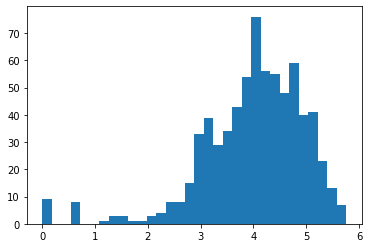

In [63]:
log_y = np.log(y)
log_y[log_y == -np.inf] = 0
plt.hist(log_y, bins=32)